# Pectoral Muscle Removal from Mammograms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab

### Ensuring same orientation of all images
In order for the algorithm to generalize over all mammograms, we first right-orient all images. To detect left-oriented breast images, we simply compare the number of nonzero pixels on both half of the images.

This is quite a rudimentary way to detect orientation, and works because the the background pixels are completely black and thus gives us an idea of the location of breast on either half of the image

In [2]:
from glob import glob
image_list = glob("/mnt/f/EMBED_1080_ROI_JPG/EMBED_1080_ROI_JPG/images/*/*/*/*/*.jpg")
print(len(image_list))

98788


In [3]:
import pandas as pd
get_orig_path = lambda x: x.replace("/mnt/NAS2/mammo/anon_dicom", '/mnt/f/EMBED_1080_ROI_JPG/EMBED_1080_ROI_JPG/images').replace('.dcm', '_resized.jpg')
df = pd.read_csv("data/tables/EMBED_OpenData_metadata_reduced.csv")
df = df[df['FinalImageType'] == '2D']
screen_idx = df['StudyDescription'].apply(lambda x: x.lower().find('screen') > 0)
df = df[screen_idx]
df['new_path'] = df['anon_dicom_path'].apply(get_orig_path)
path_to_description = dict(zip(df['new_path'], df['SeriesDescription']))

/tmp/ipykernel_82750/3618476544.py:3: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/tables/EMBED_OpenData_metadata_reduced.csv")


In [4]:
mlo_images = [path for path in image_list if 'MLO' in path_to_description.get(path, '')]
print(len(mlo_images))

2157


In [287]:
from glob import glob
image_list = glob("/mnt/j/CSAW-CC-resized-1024/data/*.png")
image_set = set(image_list)
print(len(image_list))

mlo_images = [path for path in image_list if 'MLO' in path]
print(len(mlo_images))

paired_images = [(path, path.replace('MLO', 'CC')) for path in mlo_images if path.replace('MLO', 'CC') in image_set]
print(len(paired_images))

98788
49394
49394


### Image pre-processing

We first remove the text in the image by computing the area of each separate contour in the binarized image. We then use OTSU mask to cut the unnecessary background region and then rotate the image to the right orientation

In [334]:
from PIL import Image
import cv2

def otsu_mask(img):
    median = np.median(img)
    _, thresh = cv2.threshold(img, median, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def otsu_cut(x):
    if isinstance(x, Image.Image):
        x = np.array(x)
    if x.max() <= 1:
        x = (x * 255).astype(np.uint8) # Convert to 8-bit if not already
    mask = otsu_mask(x)
    # plt.imshow(mask, cmap='gray')
    # Convert to NumPy array if not already

    # Check if the matrix is empty or has no '1's
    if mask.size == 0 or not np.any(mask):
        return Image.fromarray(x)

    # Find the rows and columns where '1' appears
    rows = np.any(mask == 255, axis=1)
    cols = np.any(mask == 255, axis=0)

    # Find the indices of the rows and columns
    min_row, max_row = np.where(rows)[0][[0, -1]]
    min_col, max_col = np.where(cols)[0][[0, -1]]

    # Crop and return the submatrix
    x = x[min_row:max_row+1, min_col:max_col+1]
    img = Image.fromarray(x)
    return img

In [7]:
from skimage import io
from skimage import color
import cv2

def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    is_flipped = (left_nonzero < right_nonzero)
    if is_flipped:
        image = cv2.flip(image, 1)

    return image, is_flipped

def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    return image

In [8]:
def remove_text_label(image):
    # Convert the image to a NumPy array if it's a PIL image
    if isinstance(image, Image.Image):
        image = np.array(image)
    convert = False
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        convert = True
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8) # Convert to 8-bit if not already

    # Binarize the image using a naive non-zero thresholding
    binary_image = (image > 0).astype(np.uint8) * 255
    
    # Apply Gaussian blur to the binarized image
    blurred_image = cv2.GaussianBlur(binary_image, (5, 5), 2.0)
    # Binarize the blurred image again
    binary_image = (blurred_image > 0).astype(np.uint8) * 255
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    
    # Create an output image to store the result
    output_image = image.copy()
    
    # Remove small connected components
    for i in range(1, num_labels):  # Start from 1 to skip the background
        area = stats[i, cv2.CC_STAT_AREA]
        if area < 1e4 and area < np.max(stats[:, cv2.CC_STAT_AREA]):  # Threshold for small areas, adjust as needed
            x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            output_image[y:y+h, x:x+w] = 0  # Set the region to black
    # if image is set to pure black, return the original image
    if np.all(output_image == 0):
        output_image = image
    if convert:
        output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2RGB)
    return output_image

/mnt/j/CSAW-CC-resized-1024/data/00020_20990909_R_CC_1_resized.png


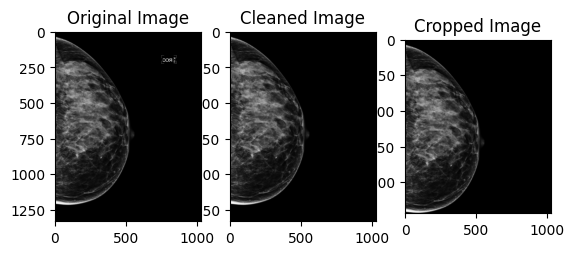

In [532]:
idx = 90
img = read_image(paired_images[idx][1])
print(paired_images[idx][1])
img = right_orient_mammogram(img)[0]
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
cleaned_img = remove_text_label(img)
plt.subplot(1, 3, 2)
plt.imshow(cleaned_img, cmap='gray')
plt.title('Cleaned Image')
img = otsu_cut(cleaned_img)
plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.title('Cropped Image')
plt.show()

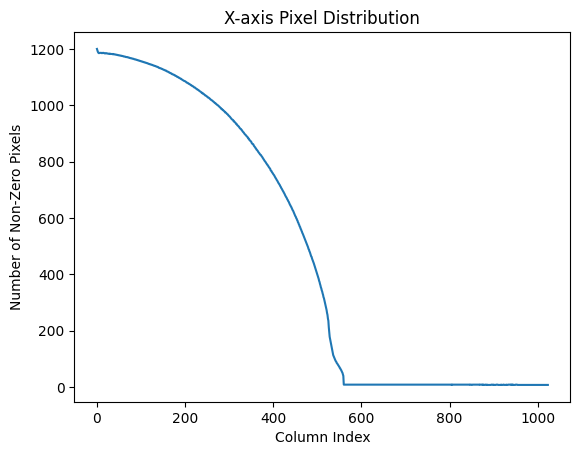

7
464 10.24


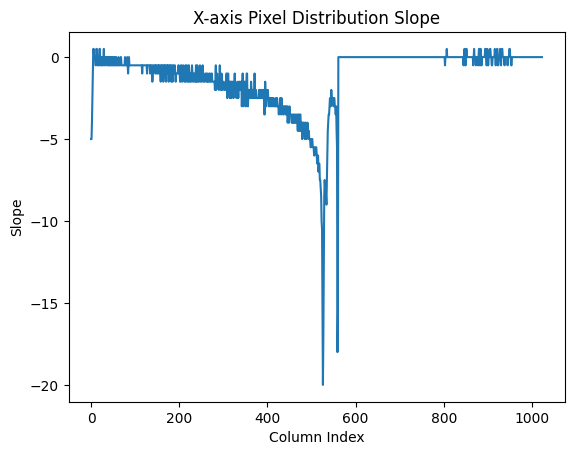

Breast right x-coordinate: 560


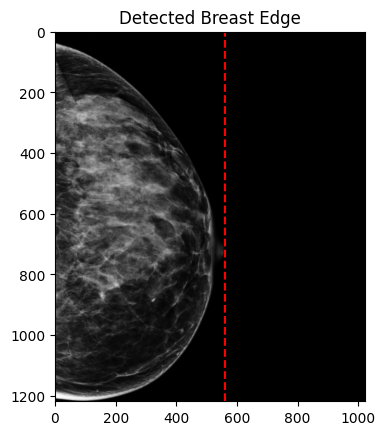

In [537]:
x_axis_dist = np.sum(np.array(img) > 0, axis=0)
plt.plot(x_axis_dist)
plt.title('X-axis Pixel Distribution')
plt.xlabel('Column Index')
plt.ylabel('Number of Non-Zero Pixels')
plt.show()
print(x_axis_dist.min())
print(np.sum(x_axis_dist < 10), 0.01 * x_axis_dist.shape[0])
x_axis_dist_slope = np.gradient(x_axis_dist)
plt.plot(x_axis_dist_slope)
plt.title('X-axis Pixel Distribution Slope')
plt.xlabel('Column Index')
plt.ylabel('Slope')
plt.show()
# Find the peak in the slope which indicates the edge of the breast
x_axis_dist_slope[x_axis_dist > np.max(x_axis_dist) * 0.1] = 0  # Ignore high intensity areas
breast_right_x_candidates = np.argsort(x_axis_dist_slope)[:5]  # Get top 5 peaks
breast_right_x = np.max(breast_right_x_candidates)
print("Breast right x-coordinate:", breast_right_x)
plt.imshow(img, cmap='gray')
plt.axvline(x=breast_right_x, color='r', linestyle='--')
plt.title('Detected Breast Edge')
plt.show()

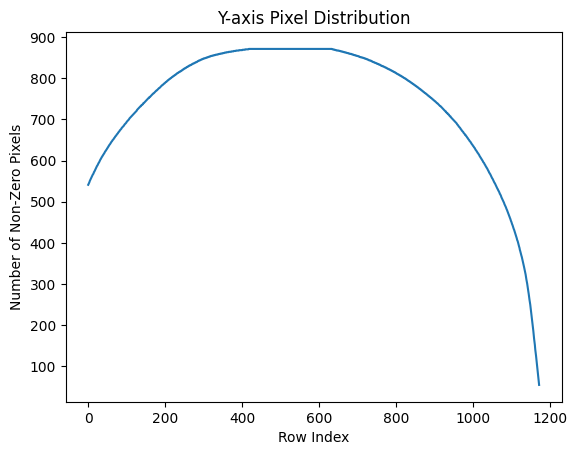

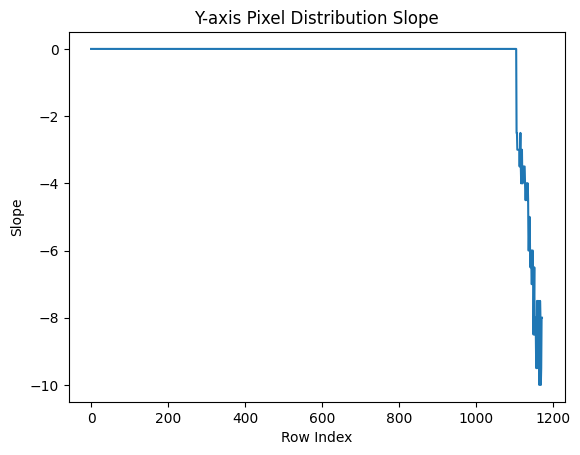

Breast bottom y-coordinate: 385


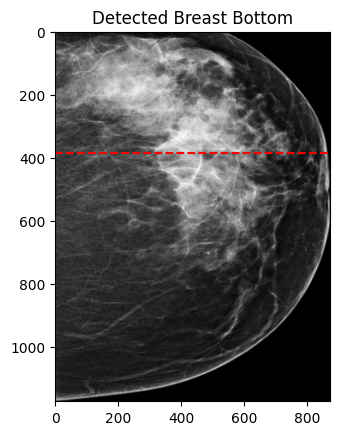

In [484]:
y_axis_dist = np.sum(np.array(img) > 0, axis=1)
plt.plot(y_axis_dist)
plt.title('Y-axis Pixel Distribution')
plt.xlabel('Row Index')
plt.ylabel('Number of Non-Zero Pixels')
plt.show()
y_axis_dist_slope = np.gradient(y_axis_dist)
y_axis_dist_slope[y_axis_dist > np.max(y_axis_dist) * 0.5] = 0  # Ignore high intensity areas
plt.plot(y_axis_dist_slope)
plt.title('Y-axis Pixel Distribution Slope')
plt.xlabel('Row Index')
plt.ylabel('Slope')
plt.show()

# Find the peak in the slope which indicates the top of the breast
breast_bottom_y_candidate = np.argsort(y_axis_dist_slope)[-5:]
breast_bottom_y = np.min(breast_bottom_y_candidate)
print("Breast bottom y-coordinate:", breast_bottom_y)
plt.imshow(img, cmap='gray')
plt.axhline(y=breast_bottom_y, color='r', linestyle='--')
plt.title('Detected Breast Bottom')
plt.show()

/mnt/j/CSAW-CC-resized-1024/data/00014_20990909_L_MLO_1_resized.png


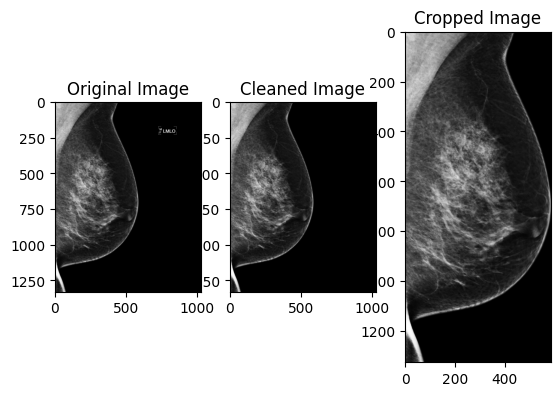

In [508]:
idx = 50
img = read_image(mlo_images[idx])
print(mlo_images[idx])
img = right_orient_mammogram(img)[0]
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
cleaned_img = remove_text_label(img)
plt.subplot(1, 3, 2)
plt.imshow(cleaned_img, cmap='gray')
plt.title('Cleaned Image')
img = otsu_cut(cleaned_img)
plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.title('Cropped Image')
plt.show()

### Enhance image contrast

Newer Mammography usually has better resolution and clearer than the old ones. We use histogram equalization to enhance the image contrast and highlight the pectoral region

In [31]:
def enhance_contrast(image):
    # Convert the image to a NumPy array if it's a PIL image
    if isinstance(image, Image.Image):
        image = np.array(image)
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8) # Convert to 8-bit if not already

    # Apply histogram equalization
    enhanced_image = cv2.equalizeHist(image)
    
    return Image.fromarray(enhanced_image)

### Applying canny edge detection

In [541]:
from skimage.feature import canny
from skimage.filters import sobel
from scipy.ndimage import gaussian_filter1d

def mask_bottom_fn(image):
    # mask out the bottom 10% of the image
    mask = np.ones(image.shape)
    mask[int(image.shape[0]*0.9):, :] = 0
    masked_image = image * mask
    return masked_image

def adaptive_mask_bottom_fn(image):
    y_axis_dist = np.sum(np.array(image) > 0, axis=1)
    y_axis_dist[:int(y_axis_dist.shape[0]*0.1)] = 0  # Ignore the top 10% of the image
    nipple_y = np.argmax(y_axis_dist)
    y_axis_dist_slope = np.gradient(y_axis_dist)
    # Find the breast bottom line as the row with the steepest negative slope and below the nipple
    y_axis_dist_slope[:nipple_y] = 0  # Ignore slopes above the nipple
    # pick the lowest position to avoid error
    breast_bottom_y_candidate = np.argsort(y_axis_dist_slope)[:5]
    breast_bottom_y = np.max(breast_bottom_y_candidate)
    # double check to ensure the intensity on the bottom line is low
    # print(y_axis_dist[breast_bottom_y], np.array(image).shape[1])
    if y_axis_dist[breast_bottom_y] > 0.25 * np.array(image).shape[1]:
        breast_bottom_y = image.shape[0] - 1  # If not, set to the bottom of the image
    # mask out the bottom part of the image
    mask = np.ones(image.shape)
    mask[breast_bottom_y:, :] = 0
    masked_image = image * mask
    return masked_image, breast_bottom_y

def adaptive_cut_top_fn(image, threshold=0.2):
    y_axis_dist = np.sum(np.array(image) > 0, axis=1)
    y_axis_dist = gaussian_filter1d(y_axis_dist, sigma=10)
    y_axis_dist[-int(y_axis_dist.shape[0]*0.5):] = 0  # Ignore the bottom 50% of the image
    # plt.figure()
    # plt.plot(y_axis_dist)
    # plt.title('Y-axis Pixel Distribution for Top Cut')
    # plt.xlabel('Row Index')
    # plt.ylabel('Number of Non-Zero Pixels')
    # plt.show()
    nipple_y = np.argmax(y_axis_dist)
    y_axis_dist_slope = np.gradient(y_axis_dist)
    y_axis_dist_slope[nipple_y:] = 0  # Ignore slopes below the nipple
    # smooth the distribution slope
    y_axis_dist_slope[y_axis_dist > np.max(y_axis_dist) * threshold] = 0  # Ignore high intensity areas
    y_axis_dist_slope = gaussian_filter1d(y_axis_dist_slope, sigma=10)
    # y_axis_dist_slope[:50] = 0
    # plt.figure()
    # plt.plot(y_axis_dist_slope)
    # plt.title('Y-axis Pixel Distribution Slope for Top Cut')
    # plt.xlabel('Row Index')
    # plt.ylabel('Slope')
    # plt.show()
    # Find the breast top line as the row with the steepest positive slope and above the nipple
    breast_top_y_candidates = np.argsort(y_axis_dist_slope)[-5:]
    breast_top_y = np.min(breast_top_y_candidates)
    if y_axis_dist[breast_top_y] > threshold * np.array(image).shape[1] or y_axis_dist_slope[breast_top_y] < 2:
        breast_top_y = 0  # If not, set to the top of the image
    # print("Breast top y-coordinate:", breast_top_y, y_axis_dist_slope[breast_top_y])
    return image[breast_top_y:, :], breast_top_y

def adaptive_cut_right_fn(image):
    # assume that image is processed with otsu_cut and remove_text_label
    x_axis_dist = np.sum(np.array(image) > 0, axis=0)
    if np.sum(x_axis_dist < 10) < 0.01 * x_axis_dist.shape[0]:
        return image, image.shape[1]
    x_axis_dist_slope = np.gradient(x_axis_dist)
    x_axis_dist_slope[x_axis_dist > np.max(x_axis_dist) * 0.5] = 0  # Ignore high intensity areas
    breast_right_x_candidates = np.argsort(x_axis_dist_slope)[:5]  # Get top 5 peaks
    breast_right_x = np.max(breast_right_x_candidates)
    return image[:, :breast_right_x], breast_right_x

def mask_right_fn(image):
    # mask out the right 40% of the image
    mask = np.ones(image.shape)
    mask[:, int(image.shape[1]*0.6):] = 0
    masked_image = image * mask
    return masked_image

def apply_canny(image, mask_bottom=True, mask_right=False):
    if np.array(image).max() <= 1:
        image = (image * 255).astype(np.uint8) # Convert to 8-bit if not already
    if mask_bottom:
        # image = mask_bottom_fn(image)
        image, _ = adaptive_mask_bottom_fn(image)
    if mask_right:
        image = mask_right_fn(image)
    canny_img = canny(image, 20)
    return sobel(canny_img)

In [370]:
def gaussian_blur(image):
    # Convert the image to a NumPy array if it's a PIL image
    if isinstance(image, Image.Image):
        image = np.array(image)
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8) # Convert to 8-bit if not already

    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (5, 5,), 10)
    
    return Image.fromarray(blurred_image)

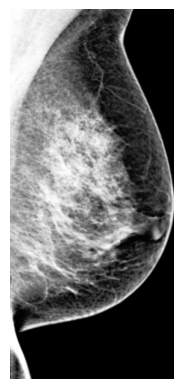

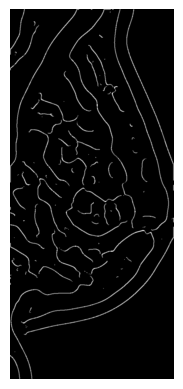

In [509]:
img = enhance_contrast(img)
img = gaussian_blur(img)
plt.figure()
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
canny_img = apply_canny(np.array(img), mask_bottom=True, mask_right=False)
plt.figure()
plt.imshow(canny_img, cmap='gray')
plt.axis('off')
plt.show()

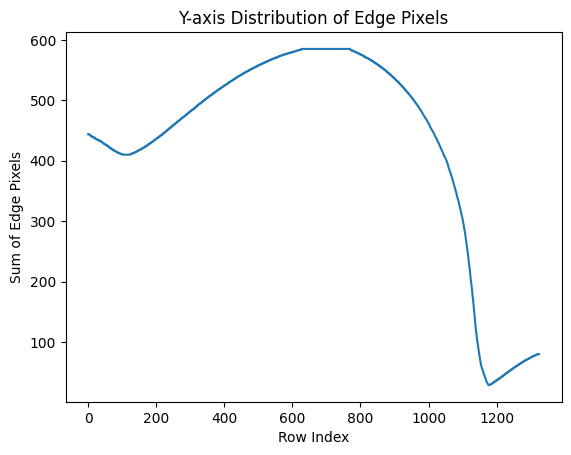

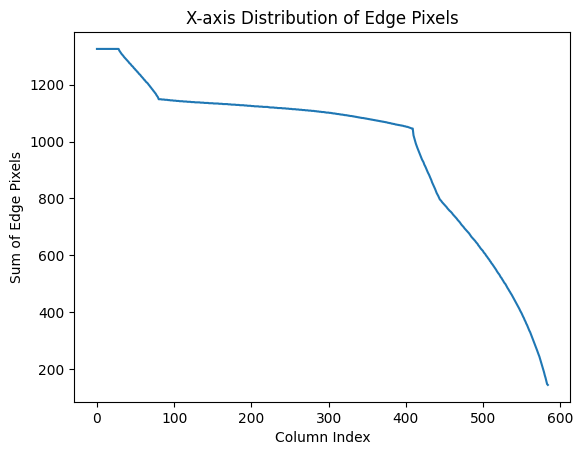

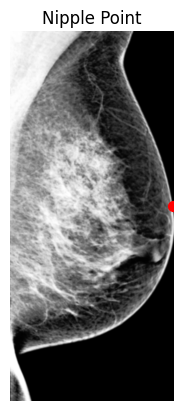

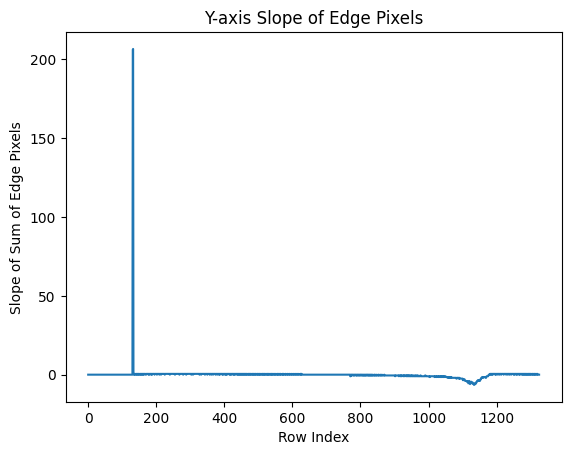

127 146.25


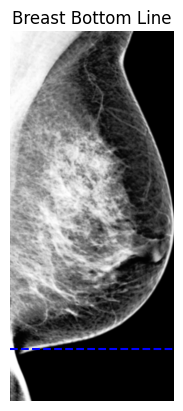

In [510]:
y_axis_dist = np.sum(np.array(img) > 0, axis=1)
x_axis_dist = np.sum(np.array(img) > 0, axis=0)
plt.figure()
plt.plot(y_axis_dist)
plt.title('Y-axis Distribution of Edge Pixels')
plt.xlabel('Row Index')
plt.ylabel('Sum of Edge Pixels')
plt.show()
plt.figure()
plt.plot(x_axis_dist)
plt.title('X-axis Distribution of Edge Pixels')
plt.xlabel('Column Index')
plt.ylabel('Sum of Edge Pixels')
plt.show()

# This is wrong since the breast is rotated in MLO view
y_axis_dist[:int(y_axis_dist.shape[0]*0.1)] = 0  # Ignore the top 10% of the image
nipple_y = np.argmax(y_axis_dist)
nipple_point = (np.array(img).shape[1] - 1, nipple_y)  # (x, y) format
# plot nipple point on the image
plt.figure()
plt.imshow(img, cmap='gray')
plt.scatter(nipple_point[0], nipple_point[1], c='r', s=50)
plt.title('Nipple Point')
plt.axis('off')
plt.show()

y_axis_dist_slope = np.gradient(y_axis_dist)
plt.figure()
plt.plot(y_axis_dist_slope)
plt.title('Y-axis Slope of Edge Pixels')
plt.xlabel('Row Index')
plt.ylabel('Slope of Sum of Edge Pixels')
plt.show()
# Find the breast bottom line as the row with the steepest negative slope and below the nipple
y_axis_dist_slope[:nipple_y] = 0  # Ignore slopes above the nipple
breast_bottom_y_candidate = np.argsort(y_axis_dist_slope)[:5]
breast_bottom_y = np.max(breast_bottom_y_candidate)
print(y_axis_dist[breast_bottom_y], 0.25 * np.array(img).shape[1])
if y_axis_dist[breast_bottom_y] > 0.25 * np.array(img).shape[1]:
    breast_bottom_y = np.array(img).shape[0]  # If not, set to the bottom of the image
# plot breast bottom line on the image
plt.figure()
plt.imshow(img, cmap='gray')
plt.axhline(y=breast_bottom_y, color='b', linestyle='--')
plt.title('Breast Bottom Line')
plt.axis('off')
plt.show()

### Applying Hough transform
Once we have obtained the edges using the Canny Edge Detector, we can apply Hough transform and make a list of output lines.

Each line is represented by an object with the following attributes
 - `dist`: perpendicular distance of the line from origin
 - `angle`: angle (in degrees) made by the perpendicular from the positive x-axis. This perpendicular is dropped on the line from the origin
 - `point1`, `point2`: two points on the line
 
Note: The x-axis and y-axis are oriented as shown in the image ouputs below.

In [251]:
def line_box_intersection(x1, y1, x2, y2, width, height):
    """
    Find the intersection points of a line defined by two points with a rectangular box.
    
    Args:
        x1, y1: First point coordinates
        x2, y2: Second point coordinates
        width, height: Box dimensions (box goes from (0,0) to (width-1, height-1))
    
    Returns:
        List of intersection points [(x, y), ...] or empty list if no intersection
    """
    # Define box boundaries
    box_left, box_right = 0, width - 1
    box_top, box_bottom = 0, height - 1
    
    intersections = []
    
    # Handle vertical line case
    if x1 == x2:
        x = x1
        if box_left <= x <= box_right:
            # Find y-range of the line segment
            y_min, y_max = min(y1, y2), max(y1, y2)
            # Intersect with box y-range
            y_start = max(y_min, box_top)
            y_end = min(y_max, box_bottom)
            if y_start <= y_end:
                intersections.append((x, y_start))
                if y_start != y_end:
                    intersections.append((x, y_end))
        return intersections
    
    # Handle horizontal line case
    if y1 == y2:
        y = y1
        if box_top <= y <= box_bottom:
            # Find x-range of the line segment
            x_min, x_max = min(x1, x2), max(x1, x2)
            # Intersect with box x-range
            x_start = max(x_min, box_left)
            x_end = min(x_max, box_right)
            if x_start <= x_end:
                intersections.append((x_start, y))
                if x_start != x_end:
                    intersections.append((x_end, y))
        return intersections
    
    # General case: non-vertical, non-horizontal line
    # Line equation: y = mx + b
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    
    # Check intersection with each box edge
    potential_intersections = []
    
    # Left edge (x = box_left)
    y_at_left = m * box_left + b
    if box_top <= y_at_left <= box_bottom:
        potential_intersections.append((box_left, y_at_left))
    
    # Right edge (x = box_right)
    y_at_right = m * box_right + b
    if box_top <= y_at_right <= box_bottom:
        potential_intersections.append((box_right, y_at_right))
    
    # Top edge (y = box_top)
    x_at_top = (box_top - b) / m
    if box_left <= x_at_top <= box_right:
        potential_intersections.append((x_at_top, box_top))
    
    # Bottom edge (y = box_bottom)
    x_at_bottom = (box_bottom - b) / m
    if box_left <= x_at_bottom <= box_right:
        potential_intersections.append((x_at_bottom, box_bottom))
    
    # Remove duplicates (corner intersections might be counted twice)
    unique_intersections = []
    tolerance = 1e-10
    
    for point in potential_intersections:
        is_duplicate = False
        for existing in unique_intersections:
            if (abs(point[0] - existing[0]) < tolerance and 
                abs(point[1] - existing[1]) < tolerance):
                is_duplicate = True
                break
        if not is_duplicate:
            unique_intersections.append(point)
    
    # Filter intersections that are actually on the line segment
    # (not just on the infinite line)
    def point_on_segment(px, py):
        # Check if point (px, py) lies on line segment from (x1, y1) to (x2, y2)
        # Using parameter t: point = (1-t)*(x1,y1) + t*(x2,y2), where 0 <= t <= 1
        if abs(x2 - x1) > tolerance:
            t = (px - x1) / (x2 - x1)
        else:
            t = (py - y1) / (y2 - y1) if abs(y2 - y1) > tolerance else 0
        
        return 0 <= t <= 1
    
    # Only keep intersections that are on the line segment
    for point in unique_intersections:
        if point_on_segment(point[0], point[1]):
            intersections.append(point)
    
    return intersections



In [258]:
from skimage.transform import hough_line, hough_line_peaks



def get_hough_lines(canny_img, verbose=False):
    h, theta, d = hough_line(canny_img)
    lines = list()
    # plt.figure()
    # plt.imshow(np.log(1 + h), extent=[np.degrees(theta[-1]), np.degrees(theta[0]), d[-1], d[0]], cmap='gray', aspect='auto')
    # plt.title('Hough Transform')
    # plt.xlabel('Angle (degrees)')
    # plt.ylabel('Distance (pixels)')
    # plt.colorbar(label='Log Accumulator Value')
    # plt.show()
    if verbose:
        print('\nAll hough lines')
    for accums, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=50, min_angle=5, threshold=0.3 * np.max(h))):
        if verbose:
            print("Angle: {:.2f}, Dist: {:.2f}, Conf: {:<.2f}".format(np.degrees(angle), dist, accums / h.max()))
        x1 = 0
        angle = max(angle, 1e-3)
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        intersections = line_box_intersection(x1, y1, x2, y2, canny_img.shape[1], canny_img.shape[0])
        # print(intersections)
        if len(intersections) != 2:
            continue
        x1, y1 = intersections[0]
        x2, y2 = intersections[1]
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2],
            'conf': accums / h.max()
        })
    
    return lines


All hough lines
Angle: -45.00, Dist: 199.00, Conf: 1.00
Angle: -62.00, Dist: 5.00, Conf: 0.87
Angle: -64.00, Dist: -829.00, Conf: 0.85
Angle: -90.00, Dist: -2.00, Conf: 0.75
Angle: 45.00, Dist: 1213.00, Conf: 0.74
Angle: -45.00, Dist: -103.00, Conf: 0.73
Angle: -58.00, Dist: -468.00, Conf: 0.71
Angle: -63.00, Dist: -758.00, Conf: 0.71
Angle: 0.00, Dist: 0.00, Conf: 0.71
Angle: -45.00, Dist: -180.00, Conf: 0.62
Angle: -65.00, Dist: -103.00, Conf: 0.60
Angle: -25.00, Dist: 105.00, Conf: 0.60
Angle: -23.00, Dist: 502.00, Conf: 0.59
Angle: 11.00, Dist: 376.00, Conf: 0.58
Angle: -69.00, Dist: -510.00, Conf: 0.58
Angle: -90.00, Dist: -1119.00, Conf: 0.56
Angle: 64.00, Dist: 1058.00, Conf: 0.54
Angle: -31.00, Dist: 9.00, Conf: 0.53
Angle: 45.00, Dist: 1006.00, Conf: 0.53
Angle: 1.00, Dist: 92.00, Conf: 0.53
Angle: 56.00, Dist: 1183.00, Conf: 0.53
Angle: -68.00, Dist: -451.00, Conf: 0.53
Angle: 15.00, Dist: 670.00, Conf: 0.51
Angle: -45.00, Dist: -8.00, Conf: 0.50
Angle: 25.00, Dist: 1092.00,

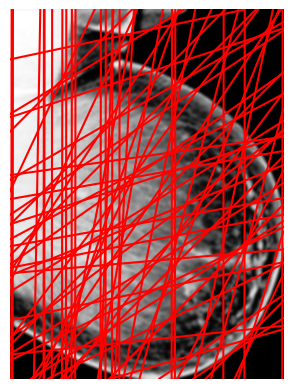

In [259]:
# plot the hough lines on the image
lines = get_hough_lines(canny_img, verbose=True)
plt.figure()
plt.imshow(img, cmap='gray')
plt.xlim(0,np.array(img).shape[1])
plt.ylim(np.array(img).shape[0])
for line in lines:
    plt.plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
plt.axis('off')
plt.show()

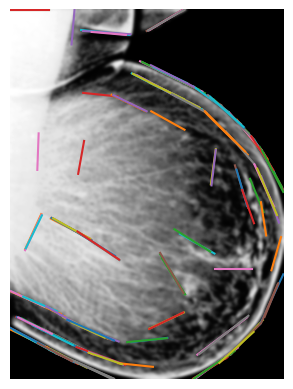

In [222]:
from skimage.transform import probabilistic_hough_line

lines = probabilistic_hough_line(canny_img, threshold=10, line_length=100, line_gap=20)
plt.figure()
plt.imshow(img, cmap='gray')
plt.xlim(0,np.array(img).shape[1])
plt.ylim(np.array(img).shape[0])
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.axis('off')
plt.show()

### Shortlisting lines
We need to shortlist possible candidates for pectoral segmentation. A simple criteria for shortlisting can be simply checking whether the `angle` and `dist` values of each line lies inside a particular interval.

The intervals are `MIN_ANGLE <= angle <= MAX_ANGLE` and `MIN_DIST <= dist <= MAX_DIST`.

These 4 parameters can be easily learned given a bigger dataset of mammograms. However, for now these have been picked manually using judgement on the given 5 images, and seem to work well.

#### TODO: consider make the dist threshold to be adaptive wrt. to the image size

In [260]:
def shortlist_lines(lines, image_width=None, verbose=False):
    MIN_ANGLE = 10
    MAX_ANGLE = 60
    MIN_DIST  = 5
    MAX_DIST  = 500
    if image_width:
        W = image_width
        MIN_DIST = max(MIN_DIST, 0.01 * W)
        MAX_DIST = min(MAX_DIST, 0.80 * W)
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    shortlisted_lines.sort(key=lambda x: x['angle'])
    if verbose:
        print('\nShorlisted lines')
        for i in shortlisted_lines:
            print("Angle: {:.2f}, Dist: {:.2f}, Conf: {:.2f}".format(i['angle'], i['dist'], i['conf']))
    return shortlisted_lines



Shorlisted lines
Angle: 10.00, Dist: 457.00, Conf: 0.42
Angle: 11.00, Dist: 376.00, Conf: 0.58
Angle: 19.00, Dist: 484.00, Conf: 0.40
Angle: 25.00, Dist: 233.00, Conf: 0.47
Angle: 25.00, Dist: 350.00, Conf: 0.38
Angle: 33.00, Dist: 434.00, Conf: 0.38
Angle: 45.00, Dist: 262.00, Conf: 0.39
Angle: 45.00, Dist: 462.00, Conf: 0.34
Angle: 59.00, Dist: 272.00, Conf: 0.46


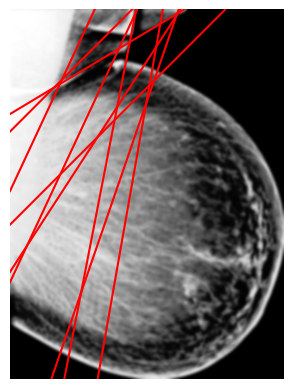

In [261]:
# plot the hough lines on the image
lines = shortlist_lines(lines, canny_img.shape[1], True)
plt.figure()
plt.imshow(img, cmap='gray')
plt.xlim(0,np.array(img).shape[1])
plt.ylim(np.array(img).shape[0])
for line in lines:
    plt.plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
plt.axis('off')
plt.show()

### Removing pectoral region
If more than one line is shortlisted, we select the one which will cause the least loss of information (the safest approach).

For this, we sort these lines by their distance from origin `dist` and pick the nearest line. Then we simply set the value to zero of those pixels enclosed within a polygon formed by the picked line and the border of the image.

In [79]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

### Pick the correct line that segment the pectoral region

Consider the situation with more than one lines in the shortlist, we want the pick the line that keep as much breast region as possible while correctly separate the pectoral region.

we note that the pectoral region usually has a different contrast than the breast region (due to its tissue composition), so we compute the STD of the ROI for each line in the shortlist and pick the one with smallest STD, namely, most tissue in the region is identical.

In [167]:
def pick_line(image, shortlist_lines):
    if len(shortlist_lines) == 0:
        return [], []
    best_line = None
    min_std = np.inf
    for line in shortlist_lines:
        rr, cc = remove_pectoral([line])
        rr = np.clip(rr, 0, image.shape[0]-1)
        cc = np.clip(cc, 0, image.shape[1]-1)
        # ignore background regions
        segmented_roi = image[rr, cc]
        segmented_roi = segmented_roi.flatten()[segmented_roi > 0]
        target_std = np.std(segmented_roi)
        if target_std < min_std:
            min_std = target_std
            best_line = line
    return [best_line], min_std

# Pick the line that minimizes the remaining intensity after removing the pectoral muscle at the top
def pick_line_top_remain(image, shortlist_lines):
    if len(shortlist_lines) == 0:
        return [], []
    best_line = None
    min_intensity = np.inf
    for line in shortlist_lines:
        rr, cc = remove_pectoral([line])
        rr = np.clip(rr, 0, image.shape[0]-1)
        cc = np.clip(cc, 0, image.shape[1]-1)
        # remove the segmented region
        segmented_img = image.copy()
        segmented_img[rr, cc] = 0
        # calculate the mean intensity of the remaining top 5% region
        top_region_intensity = np.sum(segmented_img[:, :int(0.05*image.shape[0])] > 0)
        if top_region_intensity < min_intensity:
            min_intensity = top_region_intensity
            best_line = line
    return [best_line], min_intensity

# Pick the line that minimizes the remaining intensity after removing the pectoral muscle at the top
def pick_line_conf(image, shortlist_lines):
    if len(shortlist_lines) == 0:
        return [], []
    best_line = None
    max_conf = -np.inf
    for line in shortlist_lines:
        confidence = line.get('conf', 0)
        if confidence < 0.1:  # ignore low confidence lines
            continue
        if confidence > max_conf:
            max_conf = confidence
            best_line = line
    return [best_line], max_conf

### Displaying final result
The result for all the five images is displayed below. We can easily compare the removed pectoral area with the original image.

#### TODO: rotate the image back to the correct orientation after all processing

In [531]:
import os
std_list = []
angle_list = []
def display_image(filename_pair, verbose=False, dest=None, show_img=True, filled_align=False):
    global std_list, angle_list
    filename = filename_pair[0]
    image = read_image(filename)
    cc_path = filename_pair[1]
    cc_image = read_image(cc_path)
    cc_image, _ = right_orient_mammogram(cc_image)
    cc_image = remove_text_label(cc_image)
    cc_image = otsu_cut(cc_image)
    cc_image, _ = adaptive_mask_bottom_fn(np.array(cc_image) / 255)
    cc_image = adaptive_cut_right_fn(cc_image)[0]
    cc_image = adaptive_cut_top_fn(cc_image)[0]
    cc_image = otsu_cut(cc_image)
    image, is_flipped = right_orient_mammogram(image)
    image = remove_text_label(image)
    image = otsu_cut(image)
    original_mlo_image = image.copy()
    original_mlo_image, _ = adaptive_mask_bottom_fn(np.array(original_mlo_image) / 255)
    image = enhance_contrast(image)
    image = gaussian_blur(image)
    # rescale to 0-1
    image = np.array(image) / 255
    image, breast_bottom_y = adaptive_mask_bottom_fn(image)
    # if the breast_bottom_y is zero, go up
    while image[breast_bottom_y, 0] == 0 and breast_bottom_y > 0:
        breast_bottom_y -= 1
    # plt.imshow(image, cmap='gray')
    # plt.show()
    canny_image = apply_canny(np.array(image), mask_bottom=True, mask_right=False)
    # plt.imshow(canny_image, cmap='gray')
    # plt.show()
    lines = get_hough_lines(canny_image, verbose)
    W = image.shape[1]
    shortlisted_lines = shortlist_lines(lines, image_width=W, verbose=verbose)
    # shortlisted_lines, std = pick_line(image, shortlisted_lines)
    # shortlisted_lines, std = pick_line_top_remain(image, shortlisted_lines)
    shortlisted_lines, std = pick_line_conf(image, shortlisted_lines)
    std_list.append(std)
    
    if show_img:
        fig, axes = plt.subplots(1, 6, figsize=(12,8))
        fig.tight_layout(pad=3.0)
        plt.xlim(0,image.shape[1])
        plt.ylim(image.shape[0])
        
        
        axes[0].set_title('Right-oriented')
        axes[0].imshow(original_mlo_image, cmap=pylab.cm.gray)
        axes[0].axis('on') 
        
        axes[1].set_title('Hough Lines on Canny Edge')
        axes[1].imshow(canny_image, cmap=pylab.cm.gray)
        axes[1].axis('on')
        axes[1].set_xlim(0,image.shape[1])
        axes[1].set_ylim(image.shape[0])
        for line in lines:
            axes[1].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
            
        axes[2].set_title('Shortlisted Lines')
        axes[2].imshow(canny_image, cmap=pylab.cm.gray)
        axes[2].axis('on')
        axes[2].set_xlim(0,image.shape[1])
        axes[2].set_ylim(image.shape[0])
        for line in shortlisted_lines:
            # print(line.get('conf', 0))
            # print(line)
            axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
    
    aligned_image_pair = (None, None)
    if shortlisted_lines:
        first_line = shortlisted_lines[0]
        x1, y1 = first_line['point1']
        x2, y2 = first_line['point2']
        angle = first_line['angle']
        if filled_align:
            if x1 == 0:
                y1 = int(breast_bottom_y)
                x1 = 0
                # go left until hit the breast boundary
                while image[int(y2), int(x2)] == 0 and x2 > 0:
                    x2 -= 1
                # go right until hit the breast boundary
                while image[int(y2), int(x2)] > 0 and x2 < np.array(image).shape[1] - 1:
                    x2 += 1
                # recompute the angle
                angle = 90 - np.degrees(np.arctan2(y1 - y2, x2 - x1))
                # print(x1, y1, x2, y2)
                # print(angle)
            else:
                y2 = int(breast_bottom_y)
                x2 = 0
                # go left until hit the breast boundary
                while image[int(y1), int(x1)] == 0 and x1 > 0:
                    x1 -= 1
                # go right until hit the breast boundary
                while image[int(y1), int(x1)] > 0 and x1 < np.array(image).shape[1] - 1:
                    x1 += 1
                angle = 90 - np.degrees(np.arctan2(y2 - y1, x1 - x2))
                # print(angle)
        angle_list.append(angle)
        if x1 == 0:
            center = (x1, y1)
        elif x2 == 0:
            center = (x2, y2)
        elif y1 == 0:
            center = (x1, y1)
        elif y2 == 0:
            center = (x2, y2)
        else:
            center = (image.shape[1] // 2, image.shape[0] // 2)
        # double the image width to prevent cropping during rotation
        new_width = 2 * image.shape[1]
        # Expand the image with 0s according to the new width
        expanded_image = np.zeros((image.shape[0], new_width))
        # not to use the enhanced image to preserve the original intensity
        expanded_image[:, :image.shape[1]] = original_mlo_image
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotate_image = cv2.warpAffine(expanded_image, M, (expanded_image.shape[1], expanded_image.shape[0]))
        # crop the image after rotation as additional tissue may come out after rotation
        rotate_image, _ = adaptive_mask_bottom_fn(rotate_image)
        # may harm regular cases
        rotate_image, _ = adaptive_cut_top_fn(rotate_image, threshold=0.5)
        rotate_image = otsu_cut(rotate_image)
        if show_img:
            axes[3].set_title('Rotated Image')
            axes[3].imshow(rotate_image, cmap=pylab.cm.gray)
            axes[3].axis('on')
            # display the cc image
            # resize cc image to the same width as the mlo image
            cc_image = cv2.resize(np.array(cc_image), (np.array(rotate_image).shape[1], np.array(rotate_image).shape[0]))
            axes[4].set_title('CC Image')
            axes[4].imshow(cc_image, cmap=pylab.cm.gray)
            axes[4].axis('on')
        aligned_image_pair = (rotate_image, cc_image)

        rr, cc = remove_pectoral(shortlisted_lines)
        rr = np.clip(rr, 0, original_mlo_image.shape[0]-1)
        cc = np.clip(cc, 0, original_mlo_image.shape[1]-1)
        original_mlo_image[rr, cc] = 0
        if show_img:
            original_mlo_image = otsu_cut(original_mlo_image)
            axes[5].set_title('Pectoral muscle removed')
            axes[5].imshow(original_mlo_image, cmap=pylab.cm.gray)
            axes[5].axis('on') 
            if dest:
                filename = filename.split('/')[-1]
                fig_dest = os.path.join(dest, filename).replace('.png', '_vis.png').replace('.jpg', '_vis.jpg')
                plt.savefig(fig_dest, bbox_inches='tight')
        if dest:
            filename = filename.split('/')[-1]
            dest = os.path.join(dest, filename).replace('.png', '_aligned.png').replace('.jpg', '_aligned.jpg')
            if isinstance(rotate_image, np.ndarray):
                rotate_image = Image.fromarray((rotate_image * 255).astype(np.uint8))
            else:
                rotate_image.save(dest)
    else:
        original_mlo_image, _ = adaptive_mask_bottom_fn(original_mlo_image)
        original_mlo_image, _ = adaptive_cut_top_fn(original_mlo_image)
        original_mlo_image = otsu_cut(original_mlo_image)
        if show_img:
            axes[3].set_title('Bottom trimmed Image')
            axes[3].imshow(original_mlo_image, cmap=pylab.cm.gray)
            axes[3].axis('on')
            # display the cc image
            # resize cc image to the same width as the mlo image
            cc_image = cv2.resize(np.array(cc_image), (np.array(original_mlo_image).shape[1], np.array(original_mlo_image).shape[0]))
            axes[4].set_title('CC Image')
            axes[4].imshow(cc_image, cmap=pylab.cm.gray)
            axes[4].axis('on')
            axes[5].set_title('Pectoral muscle removal skipped')
            axes[5].imshow(np.zeros_like(original_mlo_image), cmap=pylab.cm.gray)
            axes[5].axis('on')
            if dest:
                filename = filename.split('/')[-1]
                fig_dest = os.path.join(dest, filename).replace('.png', '_vis.png').replace('.jpg', '_vis.jpg')
                plt.savefig(fig_dest, bbox_inches='tight')
        aligned_image_pair = (original_mlo_image, cc_image)
        if dest:
            filename = filename.split('/')[-1]
            dest = os.path.join(dest, filename)
            # double otsu cut to remove the bottom region
            original_mlo_image = otsu_cut(original_mlo_image)
            if isinstance(original_mlo_image, np.ndarray):
                original_mlo_image = Image.fromarray((original_mlo_image * 255).astype(np.uint8))
            else:
                original_mlo_image.save(dest)
    if show_img:
        plt.show()
        plt.cla()
        plt.close()
    return aligned_image_pair

Breast top y-coordinate: 53 2.261238374303101

All hough lines
Angle: -90.00, Dist: -2.00, Conf: 1.00
Angle: 1.00, Dist: 457.00, Conf: 0.39
Angle: -17.00, Dist: 344.00, Conf: 0.38
Angle: 31.00, Dist: 440.00, Conf: 0.37
Angle: 0.00, Dist: 2.00, Conf: 0.36
Angle: 30.00, Dist: 195.00, Conf: 0.33
Angle: 3.00, Dist: 509.00, Conf: 0.32

Shorlisted lines
Angle: 30.00, Dist: 195.00, Conf: 0.33
Angle: 31.00, Dist: 440.00, Conf: 0.37
Breast top y-coordinate: 0 0.0


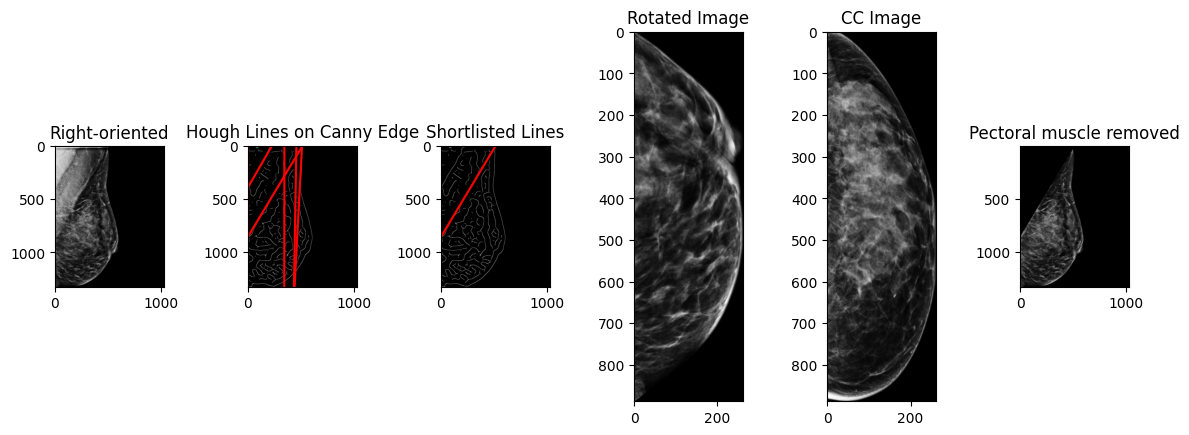

(<PIL.Image.Image image mode=L size=261x888>,
 array([[162, 164, 167, ...,   0,   0,   0],
        [144, 149, 158, ...,   0,   0,   0],
        [121, 124, 132, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8))

In [539]:
display_image(paired_images[90], verbose=True, dest=None, show_img=True, filled_align=True)

In [543]:
from tqdm import tqdm
std_list.clear()
angle_list.clear()
# save_dir = "tmp/filled_align_hough_conf/"
# os.makedirs(save_dir, exist_ok=True)
save_dir = None
pair_aligned = []
for i in tqdm(range(0, 1000)):
    aligned_image_pair = display_image(paired_images[i], verbose=False, dest=save_dir, show_img=False, filled_align=True)
    pair_aligned.append(aligned_image_pair)

100%|██████████| 1000/1000 [04:54<00:00,  3.39it/s]


In [580]:
# eval AP axis distribution

from scipy.stats import wasserstein_distance

def emd_from_samples(x, y):
    normalized_x = x / np.max(x) if np.max(x) > 0 else x
    normalized_y = y / np.max(y) if np.max(y) > 0 else y
    return wasserstein_distance(normalized_x, normalized_y)

def make_hist_probs(x, nbins=50, range_=None):
    hist, edges = np.histogram(x, bins=nbins, range=range_, density=False)
    p = hist.astype(float)
    p = p / p.sum() if p.sum() > 0 else p
    return p, edges

def kl_divergence(p, q, eps=1e-12):
    p = np.asarray(p, dtype=float); p = p / p.sum()
    q = np.asarray(q, dtype=float); q = q / q.sum()
    p = np.clip(p, eps, 1)    # avoid log(0)
    q = np.clip(q, eps, 1)
    return np.sum(p * (np.log(p) - np.log(q)))

# symmetric KL (a common convenience)
def skl(p, q, eps=1e-12):
    return 0.5 * (kl_divergence(p, q, eps) + kl_divergence(q, p, eps))

def kl_from_samples(x, y, nbins=50, range_=None, eps=1e-12):
    # shared range for fair comparison
    if range_ is None:
        lo = min(np.min(x), np.min(y))
        hi = max(np.max(x), np.max(y))
        range_ = (lo, hi)
    p, edges = make_hist_probs(x, nbins, range_)
    q, _     = make_hist_probs(y, nbins, range_)
    return kl_divergence(p, q, eps)

def mutual_information_from_samples(x, y, nbins=50, range_=None, base=2):
    x = np.asarray(x); y = np.asarray(y)

    # Shared range for fair binning
    if range_ is None:
        lo_x, hi_x = np.min(x), np.max(x)
        lo_y, hi_y = np.min(y), np.max(y)
        range_ = ((lo_x, hi_x), (lo_y, hi_y))

    H, xedges, yedges = np.histogram2d(x, y, bins=nbins, range=range_)
    Pxy = H / H.sum()

    Px = Pxy.sum(axis=1)
    Py = Pxy.sum(axis=0)

    # Safe entropy (skip zeros)
    def H_discrete(P):
        nz = P > 0
        return -np.sum(P[nz] * np.log(P[nz]))

    Hx  = H_discrete(Px)
    Hy  = H_discrete(Py)
    Hxy = H_discrete(Pxy)

    mi = Hx + Hy - Hxy          # in nats
    if base == 2:               # set base=2 for bits
        mi /= np.log(2)
    return mi

def get_ap_axis_dist(image, smooth_sigma=10):
    y_axis_dist = np.sum(np.array(image), axis=1)
    if smooth_sigma > 0:
        y_axis_dist = gaussian_filter1d(y_axis_dist, sigma=smooth_sigma)
    return y_axis_dist

def plot_1d_histogram(array, bins=50, xlabel="", ylabel="", ):
    plt.figure(figsize=(8,4))
    plt.hist(array, bins=bins, color='tab:blue', alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_paired_1d_distribution(mlo_distribution, cc_distribution, xlabel="AP axis", ylabel="Pixel count"):
    plt.figure(figsize=(8,4))
    plt.plot(mlo_distribution / np.max(mlo_distribution), label='MLO', color='b')
    plt.plot(cc_distribution / np.max(cc_distribution), label='CC', color='r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    
def display_distribution_res(mlo_image, cc_image, smooth_sigma=10, save_path=None):
    mlo_ap_dist = get_ap_axis_dist(mlo_image, smooth_sigma)
    cc_ap_dist = get_ap_axis_dist(cc_image, smooth_sigma)
    
    emd = emd_from_samples(mlo_ap_dist, cc_ap_dist)
    kld = kl_from_samples(mlo_ap_dist, cc_ap_dist, nbins=100)
    mi = mutual_information_from_samples(mlo_ap_dist, cc_ap_dist, nbins=100)
    
    plt.figure(figsize=(12,4))
    plt.title(f'AP Axis Distribution Comparison (EMD={emd:.2f}, KL={kld:.2f}, MI={mi:.2f})')
    plt.axis('off')
    plt.subplot(1, 3, 1)
    plt.imshow(mlo_image, cmap='gray')
    plt.title('MLO Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(cc_image, cmap='gray')
    plt.title('CC Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.plot(mlo_ap_dist / np.max(mlo_ap_dist), label='MLO', color='tab:blue')
    plt.fill_between(range(len(mlo_ap_dist)), mlo_ap_dist / np.max(mlo_ap_dist), alpha=0.3, color='tab:blue')
    plt.plot(cc_ap_dist / np.max(cc_ap_dist), label='CC', color='tab:red')
    plt.fill_between(range(len(cc_ap_dist)), cc_ap_dist / np.max(cc_ap_dist), alpha=0.3, color='tab:red')
    plt.xlim(0, max(len(mlo_ap_dist), len(cc_ap_dist)))
    plt.xlabel("AP axis")
    plt.ylabel("Pixel count")
    plt.legend()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    return {
        'emd': emd,
        'kld': kld,
        'mi': mi
    }

  0%|          | 0/1 [00:00<?, ?it/s]

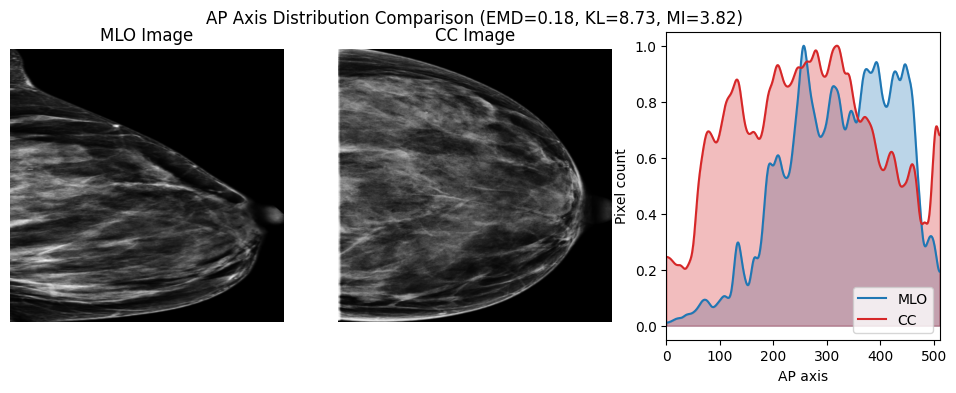

100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


In [577]:
for i in tqdm(range(1)):
    mlo_image = pair_aligned[i][0].resize((512, 512))
    cc_image = pair_aligned[i][1].resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    display_distribution_res(mlo_image, cc_image, smooth_sigma=5)

In [ ]:
os.makedirs("tmp/ap_dist/", exist_ok=True)
res_emd = []
res_kld = []
res_mi = []
for i in tqdm(range(1000)):
    mlo_image = pair_aligned[i][0].resize((512, 512))
    cc_image = pair_aligned[i][1].resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=f"tmp/ap_dist/pair_{i}.png")
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])

plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")

100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


In [28]:
print(np.mean(angle_list), np.median(angle_list))

20.987951807228917 20.000000000000004


In [26]:
print(np.mean(angle_list), np.median(angle_list))

19.801282051282055 20.000000000000004


In [24]:
print(np.mean(angle_list), np.median(angle_list))

19.056603773584907 18.0


In [22]:
print(np.mean(angle_list), np.median(angle_list))

20.635135135135137 20.000000000000004


In [20]:
print(np.mean(angle_list), np.median(angle_list))

19.718562874251496 19.0


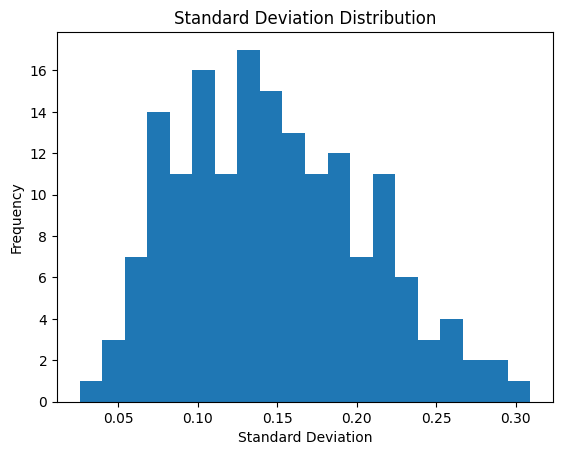

In [19]:
# plot std distribution in a histogram
std_list_arr = np.array(std_list)
plt.hist(std_list_arr[std_list_arr != 100], bins=20)
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.title('Standard Deviation Distribution')
plt.show()